**Bert model op basis van Bert van Universiteit van Groningen. Context handling moet nog aangepast worden. Oversampling a.d.h.v de mediaan. dynamisch treshhold zoeken voor unknown.**

In [1]:
import pandas as pd
import re
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import RandomOverSampler
import torch.nn.functional as F

# ✅ 1. Load & Preprocess Data
file_path = "extracted_questions_dutch.xlsx"
df = pd.read_excel(file_path)

# Drop unnecessary columns
if "TXT_file_name" in df.columns:
    df = df.drop(columns=["TXT_file_name"])

# Handle missing values
df = df.dropna(subset=["question"])
df["context"].fillna("", inplace=True)

# ✅ 2. Define Dutch Stopwords & Cleaning Function
dutch_stopwords = {"de", "het", "een", "en", "van", "ik", "te", "dat", "die", "in", "je", "is",
                   "niet", "op", "aan", "met", "als", "voor", "zijn", "was", "heeft", "heb",
                   "om", "bij", "of", "geen", "dan", "toch", "maar", "wel", "meer", "doen",
                   "ook", "kan", "mijn", "zo", "dus", "zou", "kunnen"}

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\b[a-z]\)\s+', ' ', text)  # Remove enumerations
    text = re.sub(r'\b\d+\.\b', '', text)  # Remove numbered lists
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = " ".join([word for word in text.split() if word not in dutch_stopwords])
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ✅ 3. Merge Context + Question & Apply Cleaning
df["clean_text"] = (df["context"] + " " + df["question"]).apply(clean_text)

# ✅ 4. Encode Theme Labels as Numbers
unique_themes = list(df["theme"].unique())
theme_to_id = {theme: idx for idx, theme in enumerate(unique_themes)}
id_to_theme = {idx: theme for theme, idx in theme_to_id.items()}  # ✅ Ensure mapping back from ID to theme
df["theme_id"] = df["theme"].map(theme_to_id)

# ✅ 5. Fix Class Imbalance with Oversampling
theme_counts = df["theme_id"].value_counts()
median_count = theme_counts.median()  # Set balancing threshold

# Oversample rare themes
sampling_strategy = {theme: int(median_count) for theme in theme_counts.index if theme_counts[theme] < median_count}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

X_resampled, y_resampled = ros.fit_resample(df[["clean_text"]], df["theme_id"])
df_resampled = pd.DataFrame({"clean_text": X_resampled["clean_text"], "theme_id": y_resampled})

# ✅ 6. Split Data into Train & Test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_resampled["clean_text"].tolist(), df_resampled["theme_id"].tolist(), test_size=0.2, random_state=42, stratify=df_resampled["theme_id"]
)

# ✅ 7. Load BERT Tokenizer & Define Dataset Class
model_name = "GroNLP/bert-base-dutch-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

class ThemeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        encoding["labels"] = torch.tensor(self.labels[idx])
        return {key: val.squeeze(0) for key, val in encoding.items()}

train_dataset = ThemeDataset(train_texts, train_labels, tokenizer)
test_dataset = ThemeDataset(test_texts, test_labels, tokenizer)

# ✅ 8. Load BERT Model for Classification
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_themes))

# ✅ 9. Define Training Arguments (With Early Stopping)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,  # Increased epochs
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    fp16=True,
    load_best_model_at_end=True
)

# ✅ 10. Define Metrics for Evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=1)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ✅ 11. Train Model with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement for 2 epochs
)

trainer.train()

# ✅ 13. Make Predictions (With Dynamic Confidence Threshold & Short Question Handling)
predictions = trainer.predict(test_dataset)
probabilities = F.softmax(torch.tensor(predictions.predictions), dim=1)

# ✅ Dynamically Adjust the Confidence Threshold (5th Percentile)
confidence_values = torch.max(probabilities, dim=1)[0].tolist()
dynamic_threshold = np.percentile(confidence_values, 5)  # ✅ Set threshold at the 5th percentile
print(f"Dynamic Threshold: {dynamic_threshold}")  # ✅ Print the new threshold

# ✅ Predict Themes with "Unknown" for Unclear Questions
predicted_labels = []
for i in range(len(probabilities)):
    max_prob = torch.max(probabilities[i]).item()
    pred_label = torch.argmax(probabilities[i]).item()
    question_text = test_texts[i]

    # ✅ If question is too short and lacks context, assign "Unknown"
    if len(question_text.split()) < 5:
        predicted_labels.append("Unknown")
    elif max_prob < dynamic_threshold:
        predicted_labels.append("Unknown")  # ✅ Filter out low-confidence predictions
    else:
        predicted_labels.append(id_to_theme[pred_label])  # ✅ Assign label

# ✅ 14. Save Predictions & CLS Embeddings to Excel
output_df = pd.DataFrame({
    "Text": test_texts,
    "True_Theme": [id_to_theme[label] for label in test_labels],
    "Predicted_Theme": predicted_labels
})


output_df.to_excel("bert_theme_classification.xlsx", index=False)
print("✅ Model Training Completed! Predictions saved.")


C:\Users\jefva\AppData\Local\Temp\ipykernel_9016\967100794.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["context"].fillna("", inplace=True)
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.989000,0.868064,0.774315,0.786084,0.774315,0.766242
2,0.461100,0.650401,0.828349,0.846305,0.828349,0.830163
3,0.554600,0.635626,0.848957,0.869745,0.848957,0.854999
4,0.206600,0.658844,0.857502,0.869342,0.857502,0.858213
5,0.037800,0.642321,0.864539,0.886864,0.864539,0.871973


Dynamic Threshold: 0.3641877591609955


NameError: name 'final_output_df' is not defined

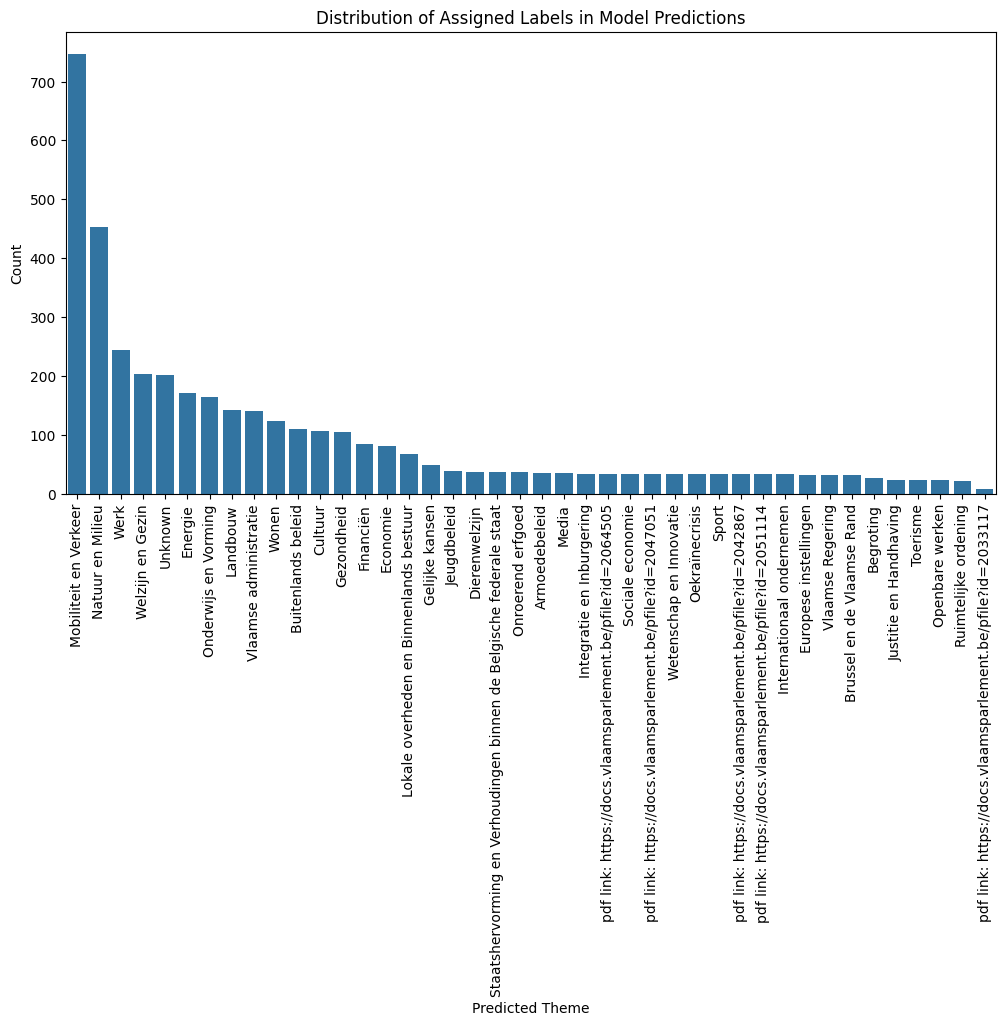

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Replace this with your actual predictions DataFrame
# Example: If your predictions are stored in a variable `predicted_labels`
# Convert it into a DataFrame for visualization
df = pd.DataFrame({"Predicted_Theme": predicted_labels})

# ✅ Count occurrences of each predicted theme
label_counts = df["Predicted_Theme"].value_counts()

# ✅ Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Predicted Theme")
plt.ylabel("Count")
plt.title("Distribution of Assigned Labels in Model Predictions")
plt.show()


In [3]:
print(predicted_labels[:10])  # Show first 10 predicted labels
print("Total predictions:", len(predicted_labels))


['Mobiliteit en Verkeer', 'Mobiliteit en Verkeer', 'Energie', 'Welzijn en Gezin', 'Mobiliteit en Verkeer', 'Natuur en Milieu', 'Financiën', 'Onroerend erfgoed', 'Onderwijs en Vorming', 'Mobiliteit en Verkeer']
Total predictions: 3979


In [4]:
print("Test dataset size:", len(test_dataset))


Test dataset size: 3979


In [6]:
# ✅ 14. Save Predictions & CLS Embeddings to Excel
output_df = pd.DataFrame({
    "Text": test_texts,
    "True_Theme": [id_to_theme[label] for label in test_labels],
    "Predicted_Theme": predicted_labels
})


output_df.to_excel("bert_theme_classification.xlsx", index=False)
print("✅ Model Training Completed! Predictions saved.")



✅ Model Training Completed! Predictions saved.


In [7]:
print("First 10 Test Texts:", test_texts[:10])
print("First 10 True Labels:", [id_to_theme[label] for label in test_labels[:10]])
print("First 10 Predicted Labels:", predicted_labels[:10])
print("Total Predictions:", len(predicted_labels))
print("Unique Predicted Labels:", set(predicted_labels))  # Ensure diversity



First 10 Test Texts: ['aanhoudende regen eerste helft november 2023 leidde tot waterellende heel vlaanderen', 'graag overzicht per provincie graag overzicht provincie westvlaanderen per gemeente locatie project omschrijving project bijhorende subsidiebedrag ziet legislatuur', 'gemeente neemt jaarabonnement allin service dyzo graag totaalaantal opdeling naar occasionele samenwerkingb jaarovereenkomstc provincied samenwerking ocmwe samenwerking gemeente an sichf samenwerking ocmw n gemeente2 hoeveel gemeenten vlaanderen werkten samen dyzo 2023', 'begeleidende maatregelen basisbegeleidingstaken sociale verhuurders overstijgen vallen onder woonbegeleiding wonensociale huurders woonbegeleidingde doelgroep sociale huisvesting groep waarin aantal combinatie huisvesting maakt groep belangrijk verschil alleen door verhuren tegen lagere huurprijzen door aandacht hebben kwetsbaarheden binnen huisvestingssituatie', 'fase 3 tegen eind 2031 volledige realisatie project rivierherstel leie uit rapport